In [7]:
import re 
import string
import unicodedata
import sys

STOPWORDS = [u"ấy", u"bị", u"bởi", u"cả", u"các", u"cái", u"cần", u"càng", u"chỉ", u"chiếc", u"cho", u"chứ", u"chưa", 
             u"chuyện", u"có", u"có_thể", u"cứ", u"của", u"cùng", u"cũng", u"đã", u"đang", u"đây", u"để", u"đến_nỗi", 
             u"đều", u"điều", u"do", u"đó", u"được", u"dưới", u"gì", u"khi", u"không", u"là", u"lại", u"lên", u"lúc", 
             u"mà", u"mỗi", u"một cách", u"này", u"nên", u"nếu", u"ngay", u"nhiều", u"như", u"nhưng", u"những", u"nơi", 
             u"nữa", u"phải", u"qua", u"ra", u"rằng", u"rất", u"rồi", u"sau", u"sẽ", u"so", u"sự", u"tại", u"theo", 
             u"thì", u"trên", u"trước", u"từ", u"từng", u"và", u"vẫn", u"vào", u"vậy", u"vì", u"việc", u"với", u"vừa",
             u"_num", u"wwdateww", u"wwtimeww", u"wwemailww", u"wwipww", u"wwurlww", u"wwnumberww"
            ]

tbl = dict.fromkeys(i for i in xrange(sys.maxunicode)
                      if unicodedata.category(unichr(i)).startswith('P') and i != 45 and i!= 95)

def vi_trans_unicode(su):
    return su.translate(tbl)

def vi_strip_text2(s):
    s = re.sub(r"&amp;", "", s)
    s = vi_trans_unicode(s)
    s = re.sub(r"<([^>]+)>", "", s)
    s = re.sub(r"(\s|\\n|\\r|\\t)+", " ", s)
    s = re.sub(r"__+", "_", s)
    s = re.sub(r"--+", "-", s)
    s = ' '.join([w if not w[0].isdigit() else u"wwNUMBERww" for w in s.strip().split()])
    return s

def vi_clean3(line):
    words = line.replace('.','').strip().split()
    words = [w.lower() for w in words]
    return ' '.join(words)

def vi_remove_stop_1char(line):
    words = line.replace('.','').strip().split()
    words = [w for w in words if w not in STOPWORDS and len(w) > 1]
    return ' '.join(words)

import requests
import codecs
import json

tok_url = "http://192.168.0.215:8081/api/v1.0/document/filter?"

def get_tokens(tok_url, data):
    try:
        rq = requests.post(tok_url, data=vi_remove_stop_1char(vi_clean3(vi_strip_text2(data))).encode('utf-8'))
        if rq.content:
            tok_doc = ' '.join(json.loads(rq.content)['sentences'])
        else:
            tok_doc = None
        return tok_doc
    except Exception, e:
        print e

## Loading Test

In [1]:
import requests
import codecs
import json
import pandas as pd

In [2]:
df = pd.read_json("/home/laampt/nlp/data/private/df_test.json")

In [3]:
df.head(5)

,Doc,Doc_Clean,Num_Words,Target
0,"Công bố kết quả kiểm tra, giám sát, đôn đốc cô...",công_bố kết_quả kiểm_tra giám_sát đôn_đốc công...,708,0
1,VTV1 KHÉO LÉO QUẢNG BÁ CUỘC GẶP CỦA TỔNG THỐNG...,vtv1 khéo_léo quảng_bá cuộc gặp của tổng_thống...,97,1
10,"Đẩy mạnh xoá đói, giảm nghèo, hạn chế phân hoá...",đẩy_mạnh xoá đói giảm nghèo hạn_chế phân_hoá g...,1136,0
100,CON CỦA THỦ TƯỚNG NGUYỄN TẤN DŨNG\n\n Chúng tô...,con của thủ_tướng nguyễn tấn dũng chúng_tôi bắ...,1249,1
101,Dốc toàn lực tìm người mất tích vụ tai nạn lò ...,dốc toàn lực tìm người mất_tích vụ tai_nạn lò ...,303,0


In [5]:
test_docs = df.Doc_Clean.values
test_labels = df.Target.values

print len(test_docs), len(test_labels)

140 140


In [8]:
test_docs_clean = []
for i, raw in enumerate(test_docs):
    if i % 100 == 0: print "[*] Progress ", i
    doc = vi_remove_stop_1char(vi_clean3(vi_strip_text2(raw)))
    test_docs_clean.append(doc)
    
print len(test_docs_clean)

[*] Progress  0
[*] Progress  100
140


In [9]:
test_docs_list = [doc.split() for doc in test_docs_clean]

## Loading models

In [10]:
from sklearn.externals import joblib

lr_tfidf = joblib.load("/home/laampt/nlp/train/estimator/19/lr_tfidf_268a_90auc.pkl")
svc_tfidf = joblib.load("/home/laampt/nlp/train/estimator/19/svc_tfidf_268a_90auc.pkl")
vectorizer_tfidf = joblib.load("/home/laampt/nlp/train/estimator/19/vectorizer_tfidf_268a_90auc.pkl")

## Tranform

In [11]:
test_data_features2 = vectorizer_tfidf.transform(test_docs_clean)
test_data_features2 = test_data_features2.toarray()

In [12]:
print test_data_features2.shape, test_labels.shape

(140, 10000) (140,)


## Performance report

In [13]:
from sklearn import metrics
import numpy as np

In [15]:
w =0.4
print "LR: {}, SVC: {}".format(w,1-w)
mega_predictions = []
for vec in test_data_features2:
    prediction = lr_tfidf.predict(vec) * w + svc_tfidf.predict(vec) * (1-w)
    prediction = 1 if (prediction[0] > 0.5) else 0
    mega_predictions.append(prediction)
print 'Mega Combinator:\n{}'.format(metrics.classification_report(test_labels, mega_predictions))
print('Mega Classifier: {:.2f} AUC'.format(metrics.roc_auc_score(test_labels, mega_predictions)))
print

LR: 0.4, SVC: 0.6
Mega Combinator:
             precision    recall  f1-score   support

          0       0.90      0.94      0.92        81
          1       0.91      0.86      0.89        59

avg / total       0.91      0.91      0.91       140

Mega Classifier: 0.90 AUC



## Visualization

In [16]:
%matplotlib inline 

import matplotlib as mlp
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') # Good looking plots
pd.set_option('display.max_columns', None) # Display any number of columns

import seaborn as sns

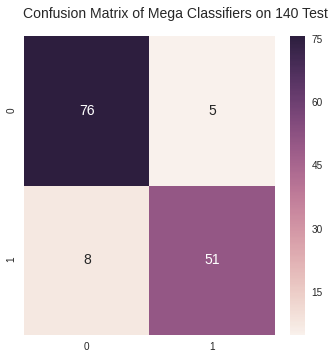

In [17]:
cm = metrics.confusion_matrix(test_labels, np.array(mega_predictions))

fix, ax = plt.subplots(figsize=(5, 5))
plt.suptitle('Confusion Matrix of Mega Classifiers on 140 Test ')
plt.subplot(1, 1, 1)
sns.heatmap(cm, annot=True,  fmt='');

In [21]:
for i, label in enumerate(mega_predictions):
    if mega_predictions[i] != test_labels[i]: 
        print test_docs[i]
        print ">> True: {} | Predict: {}".format(test_labels[i], mega_predictions[i])
        print '-' * 80

thế_giới đang đứng trước thời_khắc trọng_đại của lịch_sử là đã tiến vào thập_niên đầu của thế_kỷ xxi với một nền văn_minh rực_rỡ nhưng cũng ngổn_ngang những vấn_đề gay_gắt mang tính toàn_cầu nó chứa_đựng trong mình cả niềm_vui và sự bất_hạnh cả nụ_cười và nước mắt cả hạnh_phúc và lo_toan một trong những nỗi lo toàn_cầu nỗi đau nhân_loại là sự đói_nghèo trầm_trọng trên một phạm_vi vô_cùng rộng_lớn như thế đủ thấy đói_nghèo và giải_quyết vấn_đề nghèo_đói mang tính phổ_biến không chỉ là công_việc của_riêng nước ta tuy nhiên để hiểu về chương_trình xóa đói giảm nghèo ở nước ta một cách đầy_đủ cần_thiết phải có cách nhìn tổng_quan cần biết người biết ta để rút ra những bài_học và tìm ra những phương_pháp hữu_hiệu wwnumberww đói_nghèo và việc giải_quyết đói_nghèo trên thế_giới cho đến hôm_nay đói_nghèo vẫn là nỗi ám_ảnh thường_trực đối với cả loài_người thế_giới đã chứng_kiến những thảm_họa của chiến_tranh thảm_họa của thiên_tai dịch_bệnh với bao nỗi kinh_hoàng thế nhưng hậu_quả do những nạn

## Benchmark

In [22]:
%timeit lr_tfidf.predict(vec)

The slowest run took 7.23 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 32.9 µs per loop


In [23]:
%timeit svc_tfidf.predict(vec)

The slowest run took 6.02 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 32.7 µs per loop


In [27]:
%load_ext memory_profiler

In [28]:
%memit lr_tfidf.predict(vec)

peak memory: 142.36 MiB, increment: 0.18 MiB


In [29]:
%memit svc_tfidf.predict(vec)

peak memory: 142.42 MiB, increment: 0.06 MiB
